<a href="https://colab.research.google.com/github/JustineDataEng/Air-Quality-PM2.5-Forecasting-A-Comparative-Case-Study/blob/main/Air_Quality_Data_Auto_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell imports all the necessary libraries for data manipulation, visualization, and time series modeling.

In [ ]:
from glob import glob
import time
from datetime import datetime
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

This cell defines the `wrangle` function. This function reads a CSV file, filters for 'P2' values, renames columns, converts the timestamp to datetime, sets it as the index, converts the timezone, and then resamples the data to an hourly mean, filling missing values.

In [ ]:
def wrangle(collection):
  df = pd.read_csv(collection, sep=';')
  df = df[df["value_type"] == "P2"]
  df.drop(columns=["sensor_id",	"sensor_type",	"location",	"lat",	"lon"], inplace=True)
  df = df.rename(columns={'value': 'P2'})
  df.drop(columns=["value_type"], inplace=True)
  df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert to datetime
  df = pd.DataFrame(df).set_index("timestamp")
  df.index = df.index.tz_convert("Africa/Dar_es_Salaam") # Directly convert timezone
  df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

  return df

This cell uses the `glob` module to find all CSV files in the current directory and then prints the list of found files.

In [ ]:
files = glob('*.csv')
files


['january_2018_sensor_data_archive.csv',
 'march_2018_sensor_data_archive.csv',
 'november_2017_sensor_data_archive.csv',
 'february_2018_sensor_data_archive.csv',
 'december_2017_sensor_data_archive.csv',
 'october_2017_sensor_data_archive.csv']

This cell applies the `wrangle` function to each CSV file found and then concatenates all the processed dataframes into a single dataframe `df`. Finally, it displays the head of the combined dataframe.

In [ ]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,29,SDS011,11,-6.818,39.285,2018-01-01T00:00:04.053149+00:00,P2,9.27
1,29,SDS011,11,-6.818,39.285,2018-01-01T00:00:04.053149+00:00,P1,24.30
2,33,SDS011,11,-6.818,39.285,2018-01-01T00:00:46.551725+00:00,P1,15.63
3,33,SDS011,11,-6.818,39.285,2018-01-01T00:00:46.551725+00:00,P2,7.70
4,34,DHT22,11,-6.818,39.285,2018-01-01T00:00:48.041659+00:00,humidity,71.40


This cell generates a horizontal box plot to visualize the distribution of 'P2' (PM2.5) readings in the `df` DataFrame.

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

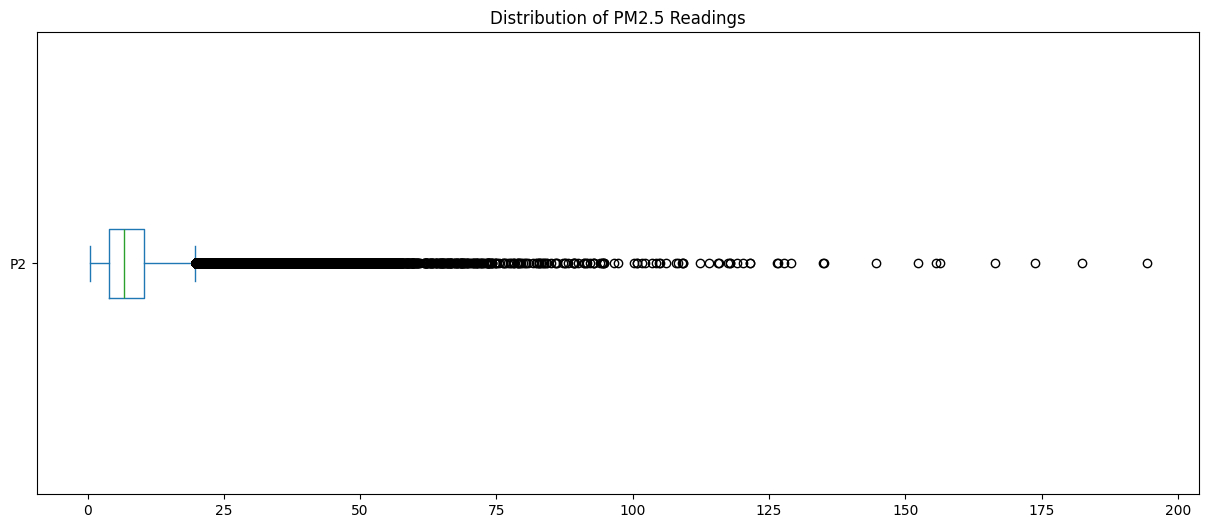

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax)

This cell plots the Autocorrelation Function (ACF) of the `df` DataFrame, which helps in identifying the dependency of the series on its past values.

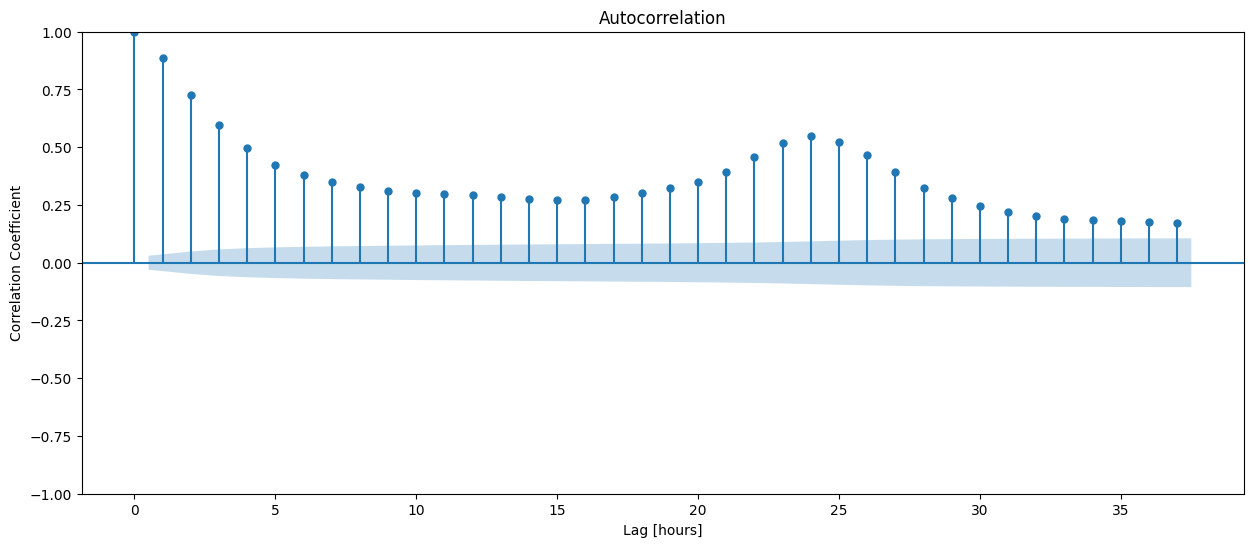

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

This cell plots the Partial Autocorrelation Function (PACF) of the `df` DataFrame, used to identify the direct relationship between an observation and its lagged values.

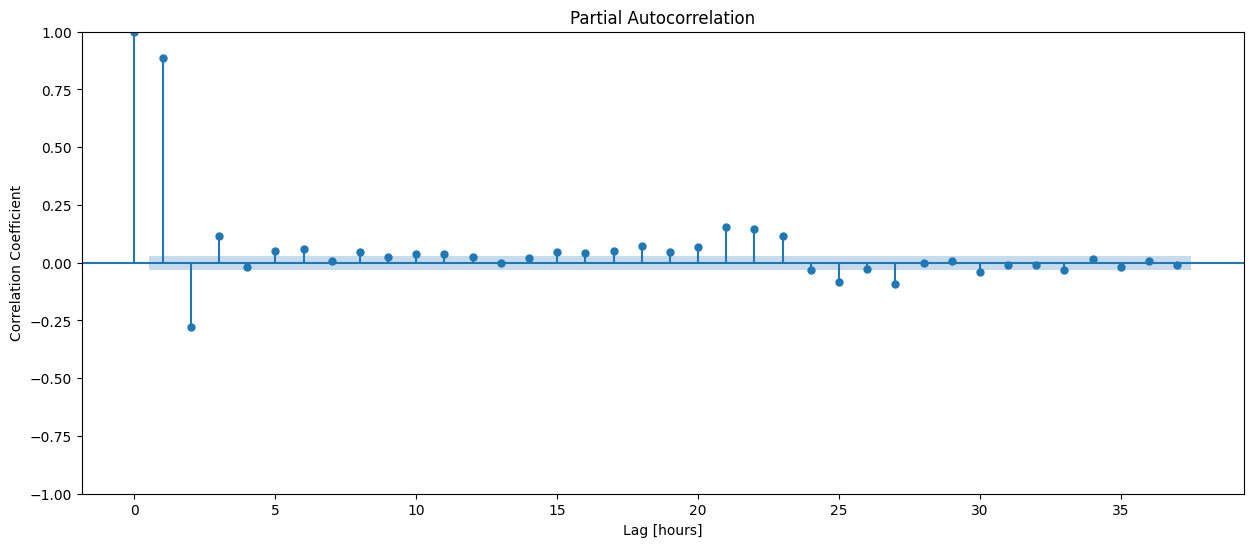

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
int(len(df))

4190

This cell splits the `df` DataFrame into training (`y_train`) and testing (`y_test`) sets, with 80% of the data allocated to the training set.

In [ ]:
cutoff_test = int(len(df) * 0.80)

y_train = df.iloc[:cutoff_test]
y_test = df.iloc[cutoff_test:]


In [ ]:
len(y_train) + len(y_test) == len(df)

True

This cell establishes a simple baseline model by calculating the mean of the training data (`y_train_mean`) and uses it to predict all values in the training set. It then computes and prints the Mean Absolute Error (MAE) for this baseline.

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: P2    8.18
dtype: float64
Baseline MAE: 3.81


This cell fits an AutoRegressive (AR) model to the training data (`y_train`) with a lag of 26. The `fit()` method estimates the model parameters.

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(y_train, lags=26).fit()

This cell checks for and counts any `NaN` (Not a Number) values in the predictions generated by the `AutoReg` model, which can occur at the beginning due to the lags.

In [ ]:
int(model.predict().isnull().sum())

26

This cell extracts the predictions from the fitted AR model, drops any `NaN` values, and then calculates the Mean Absolute Error (MAE) for the training data based on these predictions.

In [ ]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[26:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 0.9644257098921617


This cell calculates the residuals (the difference between actual and predicted values) for the training data and displays the last few entries to inspect their values.

In [ ]:
y_train_resid = model.resid
y_train_resid.tail()

,0
timestamp,
2018-02-25 00:00:00+03:00,0.149849
2018-02-25 01:00:00+03:00,0.167024
2018-02-25 02:00:00+03:00,0.171515
2018-02-25 03:00:00+03:00,0.083242
2018-02-25 04:00:00+03:00,-0.077624


This cell plots the residuals of the training data over time, which can help in visualizing any patterns or trends in the errors.

<Axes: xlabel='timestamp', ylabel='Residual Value'>

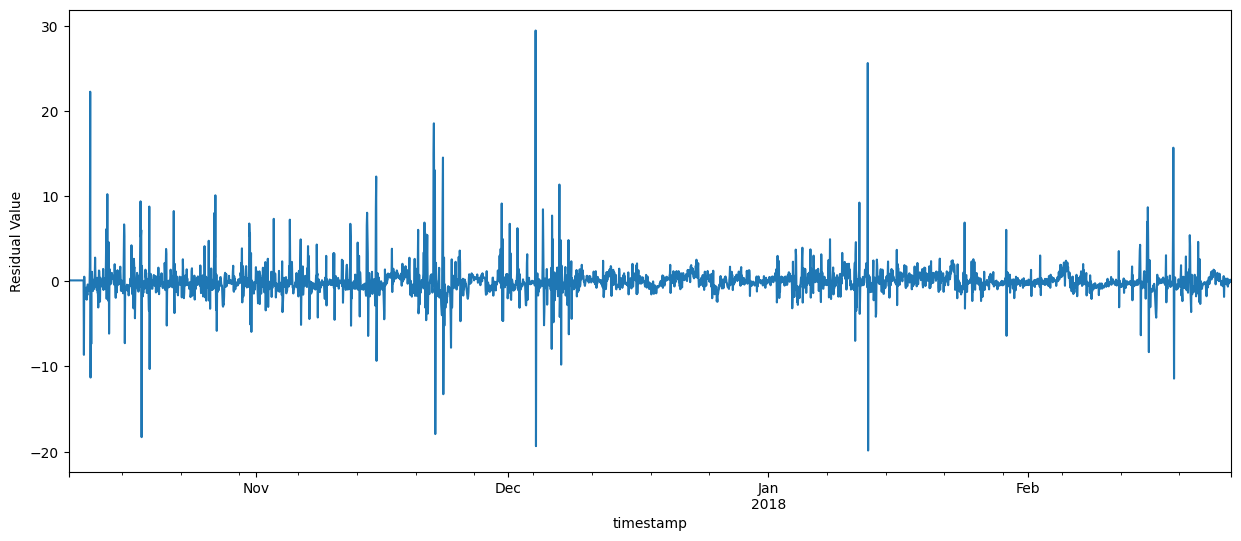

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax, )

This cell generates a histogram of the training residuals, providing insight into the distribution of the model's errors.

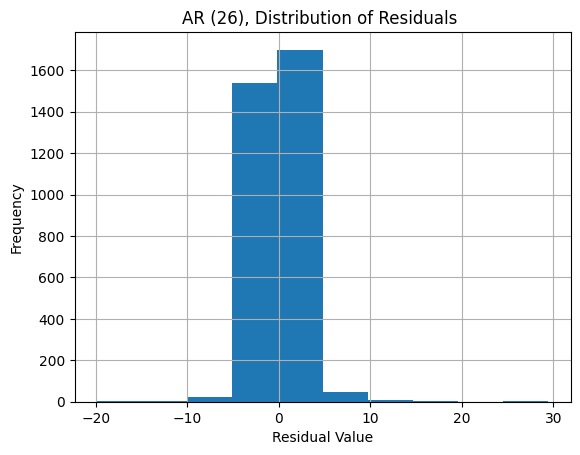

In [ ]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR (26), Distribution of Residuals ");

This cell plots the Autocorrelation Function (ACF) of the training residuals to check if there is any remaining autocorrelation in the errors, which would indicate that the model has not captured all the patterns in the data.

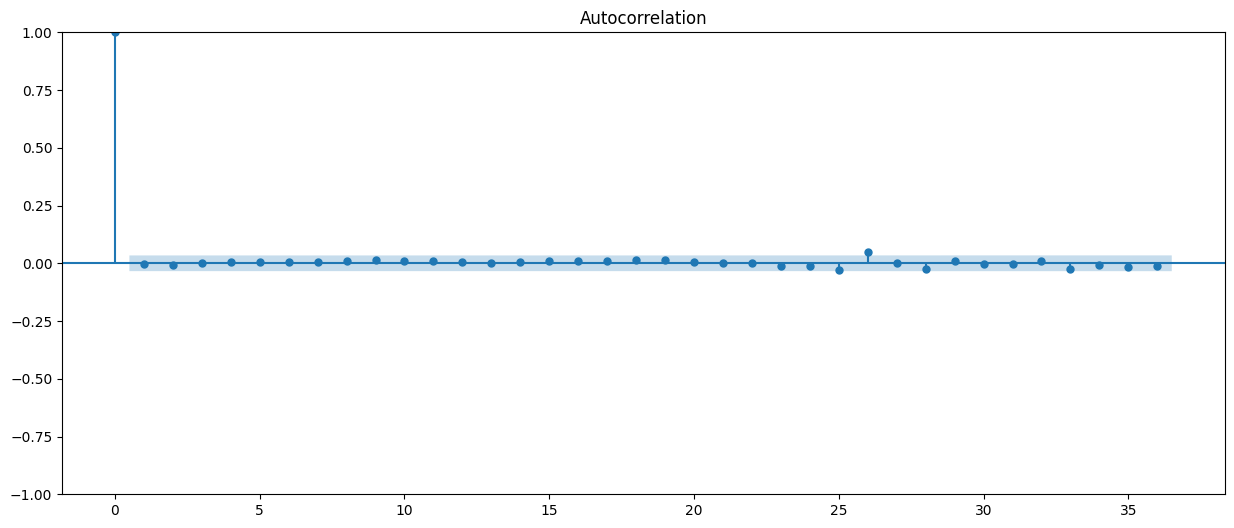

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

This cell uses the fitted AR model to predict values for the test set (`y_test`) and then calculates the Mean Absolute Error (MAE) for these test predictions.

In [ ]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 4.495897758951979


This cell creates a new DataFrame `df_pred_test` to store the actual test values (`y_test`) and the corresponding predictions (`y_pred_test`) for easy comparison and visualization.

In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test["P2"], "y_pred": y_pred_test}, index=y_test.index
)

This cell uses `plotly.express` to generate an interactive line plot comparing the actual test values and the predicted values from the AR model.

In [ ]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

This cell defines the `evaluate_autoreg_wfv` function, which performs walk-forward validation to evaluate an `AutoReg` model for a given number of lags. It iteratively fits the model, makes a one-step-ahead prediction, and updates the training history, returning the MAE.

In [ ]:
def evaluate_autoreg_wfv(lags_val, y_train_data, y_test_data):
    """
    Evaluates an AutoReg model with walk-forward validation for a given number of lags.
    Returns the Mean Absolute Error (MAE).
    """
    y_pred_wfv_local = pd.Series()
    history_local = y_train_data.copy()

    for i in range(len(y_test_data)):
        try:
            model_local = AutoReg(history_local, lags=lags_val).fit()
            next_pred_local = model_local.forecast()
            y_pred_wfv_local = pd.concat([y_pred_wfv_local, next_pred_local])
            history_local = pd.concat([history_local, y_test_data.loc[next_pred_local.index]])
        except Exception as e:
            # Handle cases where model might fail to fit (e.g., not enough data for lags)
            print(f"Error with lags={lags_val} at step {i}: {e}")
            return np.inf # Return a very high MAE to indicate failure

    if len(y_pred_wfv_local) > 0:
        # Ensure indexes are aligned before calculating MAE
        y_pred_wfv_local.index = y_test_data.index
        mae = mean_absolute_error(y_test_data, y_pred_wfv_local)
    else:
        mae = np.inf # If no predictions were made, consider it a failure

    return mae

This cell performs a grid search to find the optimal number of lags for the `AutoReg` model using the `evaluate_autoreg_wfv` function. It iterates through a range of lags (1 to 48 hours) and records the MAE for each, storing the results in `grid_search_df`.

In [ ]:
# Define the range of lags to test
lags_to_test = range(1, 49) # Testing lags from 1 to 48 hours

results = []
for lags in lags_to_test:
    print(f"Evaluating AutoReg with lags={lags}...")
    mae = evaluate_autoreg_wfv(lags, y_train, y_test)
    results.append({'lags': lags, 'mae': mae})
    print(f"  Lags={lags}, MAE={mae:.4f}")

grid_search_df = pd.DataFrame(results)


Evaluating AutoReg with lags=1...
  Lags=1, MAE=1.8477
Evaluating AutoReg with lags=2...
  Lags=2, MAE=1.7722
Evaluating AutoReg with lags=3...
  Lags=3, MAE=1.7774
Evaluating AutoReg with lags=4...
  Lags=4, MAE=1.7778
Evaluating AutoReg with lags=5...
  Lags=5, MAE=1.7814
Evaluating AutoReg with lags=6...
  Lags=6, MAE=1.7924
Evaluating AutoReg with lags=7...
  Lags=7, MAE=1.7957
Evaluating AutoReg with lags=8...
  Lags=8, MAE=1.7949
Evaluating AutoReg with lags=9...
  Lags=9, MAE=1.7935
Evaluating AutoReg with lags=10...
  Lags=10, MAE=1.7973
Evaluating AutoReg with lags=11...
  Lags=11, MAE=1.7987
Evaluating AutoReg with lags=12...
  Lags=12, MAE=1.7992
Evaluating AutoReg with lags=13...
  Lags=13, MAE=1.8003
Evaluating AutoReg with lags=14...
  Lags=14, MAE=1.8009
Evaluating AutoReg with lags=15...
  Lags=15, MAE=1.8006
Evaluating AutoReg with lags=16...
  Lags=16, MAE=1.8050
Evaluating AutoReg with lags=17...
  Lags=17, MAE=1.8044
Evaluating AutoReg with lags=18...
  Lags=18, MAE

This cell identifies the optimal number of lags from the `grid_search_df` by finding the entry with the minimum Mean Absolute Error (MAE) and prints the optimal lags and the corresponding best MAE.

In [ ]:
# Find the best lags value
best_result = grid_search_df.loc[grid_search_df['mae'].idxmin()]
optimal_lags = int(best_result['lags'])
best_mae = best_result['mae']

print(f"Optimal number of lags: {optimal_lags}")
print(f"Best MAE: {best_mae:.4f}")


Optimal number of lags: 2
Best MAE: 1.7722


This cell generates an interactive line plot using `plotly.express` to visualize the Mean Absolute Error (MAE) against the number of lags tested during the grid search, helping to see the performance trend.

In [ ]:
# Plot the results of the grid search
fig = px.line(grid_search_df, x='lags', y='mae', title='AutoReg MAE vs. Number of Lags (Walk-Forward Validation)')
fig.update_layout(xaxis_title='Number of Lags', yaxis_title='Mean Absolute Error (MAE)')
fig.show()


This cell performs walk-forward validation using the AutoReg model with an optimal lag of 2. It iteratively fits the model, predicts the next step, and updates the history with the actual observed value from the test set.

In [ ]:
%%capture
# Define a walk-forward variable
y_pred_wfv = pd.Series()
# Define a variable that takes into account what's happened in the past
history = y_train.copy()
# The `for` loop tells the model what to do with those variables.
for i in range(len(y_test)):
    # Generate the actual AR model
    model = AutoReg(history, lags=2).fit()
    # Using `forecast` to create our next prediction
    next_pred = model.forecast()
    # Adding the next prediction to the list
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    # And finally updating `history` to take into account the new observation
    history = pd.concat([history, y_test.loc[next_pred.index]])

This cell calculates and prints the Mean Absolute Error (MAE) for the walk-forward validation predictions (`y_pred_wfv`) against the actual test data (`y_test`).

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.77


This cell calculates and prints the R-squared score for both the walk-forward validation predictions and the initial training data predictions, providing a measure of how well the model explains the variance in the target variable.

In [ ]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test['P2'], y_pred_wfv)
print(f"R-squared score for walk-forward test data: {r2_test:.4f}")

r2_train = r2_score(y_train['P2'][26:], y_pred)
print(f"R-squared score for training data: {r2_train:.4f}")

R-squared score for walk-forward test data: 0.7386
R-squared score for training data: 0.8492


This cell prints the estimated parameters (coefficients) of the last fitted `AutoReg` model during the walk-forward validation, indicating the strength and direction of the relationship between the target variable and its lagged values.

In [ ]:
print(model.params)

const     0.407714
P2.L1     1.094598
P2.L2    -0.380806
P2.L3     0.144281
P2.L4    -0.052073
P2.L5    -0.026283
P2.L6     0.060199
P2.L7    -0.033239
P2.L8     0.027634
P2.L9    -0.006385
P2.L10   -0.001263
P2.L11   -0.001049
P2.L12    0.028450
P2.L13   -0.008905
P2.L14   -0.019425
P2.L15   -0.000305
P2.L16    0.013318
P2.L17   -0.015697
P2.L18    0.025119
P2.L19    0.026234
P2.L20   -0.060755
P2.L21    0.029156
P2.L22    0.013258
P2.L23    0.130210
P2.L24    0.053081
P2.L25   -0.062354
P2.L26   -0.026652
dtype: float64


This cell calculates the residuals for the walk-forward validation by subtracting the predictions from the actual test values. It then prints the mean and standard deviation of these residuals to assess their central tendency and spread.

In [ ]:
y_pred_wfv.index = y_test.index # Ensure indexes are aligned
residuals_wfv = y_test['P2'] - y_pred_wfv

print("Mean of residuals:", residuals_wfv.mean())
print("Standard deviation of residuals:", residuals_wfv.std())

Mean of residuals: 0.030471469877807602
Standard deviation of residuals: 3.3575523091881174


This cell generates a histogram of the residuals from the walk-forward validation, providing a visual representation of their distribution and helping to identify if they are normally distributed around zero.

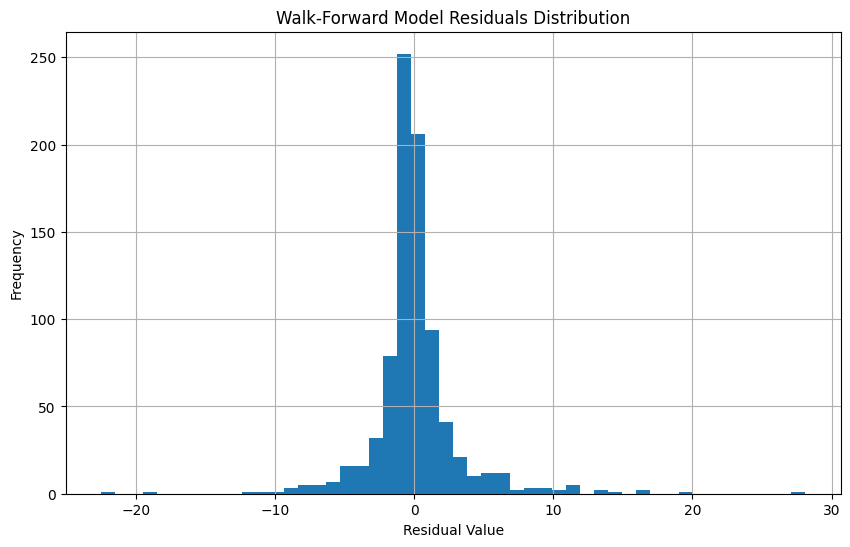

In [ ]:
plt.figure(figsize=(10, 6))
residuals_wfv.hist(bins=50)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Walk-Forward Model Residuals Distribution");

This cell plots the Autocorrelation Function (ACF) of the residuals from the walk-forward validation, which helps to determine if there is any remaining autocorrelation in the errors after applying the model.

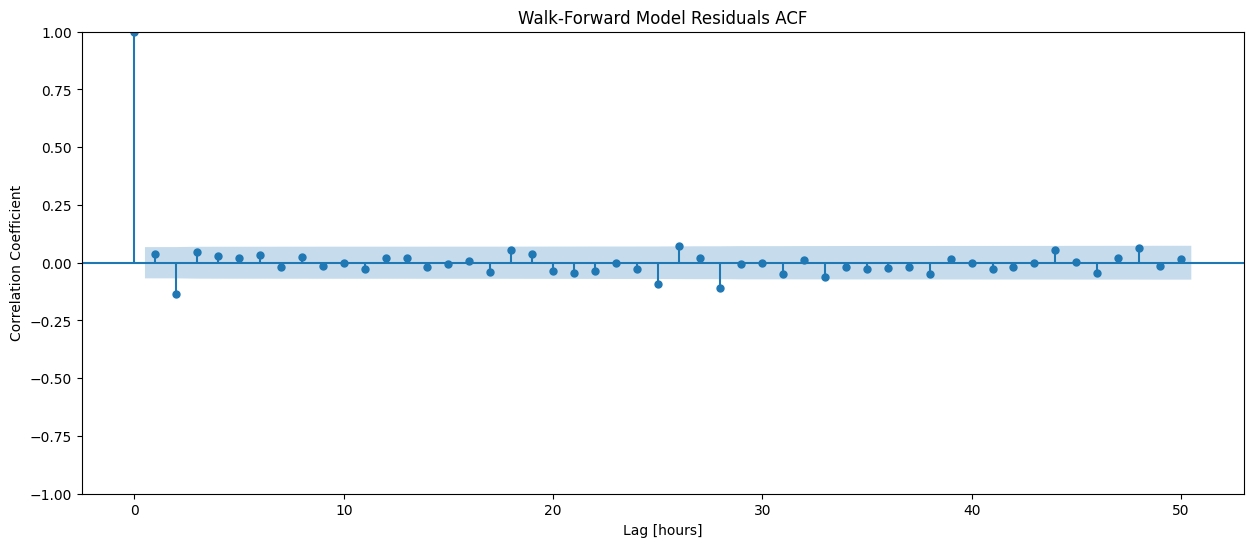

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(residuals_wfv, ax=ax, lags=50)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");
plt.title("Walk-Forward Model Residuals ACF");

This cell creates a DataFrame to compare the actual test values (`y_test`) with the predictions from the walk-forward validation (`y_pred_wfv`) and then generates an interactive line plot using Plotly Express to visualize their comparison.

In [ ]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test["P2"], "y_pred_wfv": y_pred_wfv}
)

fig = px.line(df_pred_test, labels={"value":"PM2.5"})
fig.show()